In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, AutoTokenizer
from peft import LoraConfig, get_peft_model
import os
from tqdm import tqdm

c:\Users\chucu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SketchToAnimeSDDataset(Dataset):
    def __init__(self, sketch_dir, anime_dir, image_size=512, tokenizer=None):
        self.sketch_dir = sketch_dir
        self.anime_dir = anime_dir
        
        # Asegurarse de que los archivos estén alineados
        self.sketches = sorted([f for f in os.listdir(sketch_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        self.animes = sorted([f for f in os.listdir(anime_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        
        # Verificar que tengamos el mismo número de archivos
        assert len(self.sketches) == len(self.animes), "Número diferente de sketches y animes"
        
        self.image_size = image_size
        self.tokenizer = tokenizer or AutoTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
        
        # Transformaciones para las imágenes
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
        # Prompt fijo para entrenamiento
        self.prompt = "anime style, high quality, detailed"

    def __len__(self):
        return len(self.sketches)

    def __getitem__(self, idx):
        sketch_path = os.path.join(self.sketch_dir, self.sketches[idx])
        anime_path = os.path.join(self.anime_dir, self.animes[idx])

        # Cargar imágenes
        sketch = Image.open(sketch_path).convert("RGB")
        anime = Image.open(anime_path).convert("RGB")
        
        # Aplicar transformaciones
        sketch_tensor = self.transform(sketch)
        anime_tensor = self.transform(anime)
        
        # Tokenizar el prompt
        text_inputs = self.tokenizer(
            self.prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        
        return {
            "sketch": sketch_tensor,
            "anime": anime_tensor,
            "input_ids": text_inputs.input_ids[0],
            "prompt": self.prompt
        }

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model_id = "runwayml/stable-diffusion-v1-5"
batch_size = 1  # Reducido por la memoria de 6GB
image_size = 512
num_epochs = 40
learning_rate = 1e-4

# Cargar tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer")

# Cargar modelos
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

In [5]:
dataset = SketchToAnimeSDDataset(
	sketch_dir=r"E:\polo ia pachecos\drawnime\data\sketches",
	anime_dir=r"E:\polo ia pachecos\drawnime\data\animes",
	image_size=512,
	tokenizer=tokenizer
)
train_loader = DataLoader(dataset, batch_size, shuffle=True)
# solo usar 2000 ejemplos
train_loader = DataLoader(torch.utils.data.Subset(dataset, list(range(2000))), batch_size, shuffle=True)

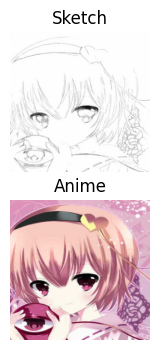

In [6]:
from matplotlib import pyplot as plt


batch = next(iter(train_loader))
plt.figure(figsize=(10, 4))
for i in range(batch_size):
    plt.subplot(2, batch_size, i+1)
    plt.imshow(((batch["sketch"][i].permute(1, 2, 0) * 0.5) + 0.5))
    plt.title("Sketch")
    plt.axis("off")
    plt.subplot(2, batch_size, i+1+batch_size)
    plt.imshow(((batch["anime"][i].permute(1, 2, 0) * 0.5) + 0.5))
    plt.title("Anime")
    plt.axis("off")
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, AutoTokenizer
from peft import LoraConfig, get_peft_model
import os
from tqdm import tqdm

def setup_lora(unet, text_encoder):
    # Configuración LoRA para UNet
    lora_config = LoraConfig(
        r=16,  # Rank
        lora_alpha=32,
        target_modules=["to_k", "to_q", "to_v", "to_out.0", "proj_in", "proj_out"],
        lora_dropout=0.1,
    )
    
    unet = get_peft_model(unet, lora_config)
    unet.print_trainable_parameters()
    
    return unet, text_encoder

def train_sketch_to_anime(unet, vae, text_encoder, train_loader, scheduler):
    # Mover a GPU
    vae.to(device)
    unet.to(device)
    text_encoder.to(device)
    
    # Congelar VAE y text encoder
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    
    # Aplicar LoRA solo a UNet
    unet, text_encoder = setup_lora(unet, text_encoder)
    
    # Optimizador solo para parámetros entrenables
    optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

    unet.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in progress_bar:
            # Mover datos a GPU
            sketches = batch["sketch"].to(device)
            animes = batch["anime"].to(device)
            input_ids = batch["input_ids"].to(device)
            
            # Codificar imágenes con VAE (usamos los animes como target)
            with torch.no_grad():
                # Codificar imágenes anime a latents
                anime_latents = vae.encode(animes).latent_dist.sample()
                anime_latents = anime_latents * vae.config.scaling_factor
                
                # Codificar sketches para condición
                sketch_latents = vae.encode(sketches).latent_dist.sample()
                sketch_latents = sketch_latents * vae.config.scaling_factor
            
            # Sample noise
            noise = torch.randn_like(anime_latents)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (anime_latents.shape[0],), device=device)
            
            # Add noise to latents
            noisy_latents = scheduler.add_noise(anime_latents, noise, timesteps)
            
            # Codificar texto
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]
            
            # Predicción del noise - CORREGIDO
            noise_pred = unet(
                noisy_latents, 
                timesteps, 
                encoder_hidden_states,
                added_cond_kwargs={"image_embeds": sketch_latents}
            ).sample
            
            # Loss - comparar con el noise original
            loss = F.mse_loss(noise_pred, noise)
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        # Guardar checkpoint cada 10 épocas
        if (epoch + 1) % 1 == 0:
            save_path = f"./lora_checkpoint_epoch_{epoch+1}"
            os.makedirs(save_path, exist_ok=True)
            unet.save_pretrained(save_path)
            print(f"Checkpoint guardado en {save_path}")
    
    # Guardar modelo final
    unet.save_pretrained("./sketch_to_anime_lora_final")
    print("Entrenamiento completado!")

In [41]:
def load_checkpoint_and_continue_training(checkpoint_path, starting_epoch):
    # Configuración
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_id = "runwayml/stable-diffusion-v1-5"
    batch_size = 1
    num_epochs = 100
    learning_rate = 1e-4
    
    print(f"🔄 Continuando desde checkpoint: {checkpoint_path}, época: {starting_epoch}")
    
    # Cargar tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id, subfolder="tokenizer")
    
    # Cargar modelos base
    vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
    unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
    text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
    scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
    
    # Mover a GPU
    vae.to(device)
    unet.to(device)
    text_encoder.to(device)
    
    # Congelar VAE y text encoder
    vae.requires_grad_(False)
    text_encoder.requires_grad_(False)
    
    # 🔥 CORRECCIÓN: Cargar LoRA con configuración explícita para entrenamiento
    from peft import PeftModel, PeftConfig
    
    print("📥 Cargando checkpoint LoRA...")
    
    # Primero cargar la configuración
    peft_config = PeftConfig.from_pretrained(checkpoint_path)
    
    # Cargar el modelo LoRA específicamente para entrenamiento
    unet = PeftModel.from_pretrained(
        unet, 
        checkpoint_path,
        is_trainable=True  # 🔥 IMPORTANTE: Habilitar entrenamiento
    )
    
    # 🔥 VERIFICAR que los parámetros LoRA requieren gradientes
    print("🔍 Verificando parámetros entrenables...")
    trainable_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in unet.parameters())
    print(f"📊 Parámetros entrenables: {trainable_params:,} / {total_params:,}")
    
    # 🔥 FORZAR modo entrenamiento
    unet.train()
    for name, param in unet.named_parameters():
        if "lora" in name.lower():
            param.requires_grad = True
    
    # Optimizador - solo parámetros que requieren grad
    trainable_params = [p for p in unet.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=learning_rate)
    
    # Cargar estado del optimizer si existe
    optimizer_path = os.path.join(checkpoint_path, "optimizer.pt")
    if os.path.exists(optimizer_path):
        try:
            optimizer.load_state_dict(torch.load(optimizer_path))
            print("✅ Optimizer cargado desde checkpoint")
        except:
            print("⚠️ No se pudo cargar el optimizer, iniciando nuevo")
    
    # Dataset
    dataset = SketchToAnimeSDDataset(
        sketch_dir=r"E:\polo ia pachecos\drawnime\data\sketches",
        anime_dir=r"E:\polo ia pachecos\drawnime\data\animes", 
        image_size=512,
        tokenizer=tokenizer
    )
    
    train_loader = DataLoader(
        torch.utils.data.Subset(dataset, list(range(2000))), 
        batch_size=batch_size, 
        shuffle=True
    )
    
    print(f"📊 Entrenando con {len(train_loader.dataset)} imágenes")
    
    # Continuar entrenamiento desde la época del checkpoint
    for epoch in range(starting_epoch, num_epochs):
        unet.train()  # 🔥 Asegurar modo entrenamiento en cada época
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch_idx, batch in enumerate(progress_bar):
            sketches = batch["sketch"].to(device)
            animes = batch["anime"].to(device)
            input_ids = batch["input_ids"].to(device)
            
            with torch.no_grad():
                anime_latents = vae.encode(animes).latent_dist.sample() * vae.config.scaling_factor
                sketch_latents = vae.encode(sketches).latent_dist.sample() * vae.config.scaling_factor
            
            noise = torch.randn_like(anime_latents)
            timesteps = torch.randint(0, scheduler.num_train_timesteps, (anime_latents.shape[0],), device=device)
            noisy_latents = scheduler.add_noise(anime_latents, noise, timesteps)
            
            with torch.no_grad():
                encoder_hidden_states = text_encoder(input_ids)[0]
            
            # 🔥 VERIFICAR que estamos en modo entrenamiento
            noise_pred = unet(
                noisy_latents, 
                timesteps, 
                encoder_hidden_states,
                added_cond_kwargs={"image_embeds": sketch_latents}
            ).sample
            
            # 🔥 VERIFICAR que noise_pred requiere gradientes
            if not noise_pred.requires_grad:
                print(f"⚠️ Batch {batch_idx}: noise_pred no requiere gradientes!")
                # Forzar recalculo con gradientes
                noise_pred = unet(
                    noisy_latents, 
                    timesteps, 
                    encoder_hidden_states,
                    added_cond_kwargs={"image_embeds": sketch_latents}
                ).sample
            
            loss = F.mse_loss(noise_pred, noise)
            
            # 🔥 VERIFICAR que la loss tiene grad_fn
            if loss.grad_fn is None:
                print(f"❌ Batch {batch_idx}: Loss no tiene grad_fn!")
                continue
            
            optimizer.zero_grad()
            loss.backward()
            
            # Verificar gradientes
            has_gradients = any(p.grad is not None for p in unet.parameters() if p.requires_grad)
            if not has_gradients:
                print(f"⚠️ Batch {batch_idx}: No hay gradientes!")
            else:
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
            
            epoch_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})
        
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            save_path = f"./lora_checkpoint_epoch_{epoch+1}"
            os.makedirs(save_path, exist_ok=True)
            unet.save_pretrained(save_path)
            torch.save(optimizer.state_dict(), os.path.join(save_path, "optimizer.pt"))
            print(f"💾 Checkpoint guardado en {save_path}")

    # Guardar modelo final
    unet.save_pretrained("./sketch_to_anime_lora_final")
    print("✅ Entrenamiento completado!")

In [ ]:
# Run training function
train_sketch_to_anime(unet, vae, text_encoder, train_loader, scheduler)

trainable params: 3,987,456 || all params: 863,508,420 || trainable%: 0.4618


Epoch 1/40:   0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\chucu\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/40: 100%|██████████| 2000/2000 [24:59<00:00,  1.33it/s, loss=0.11]   


Epoch 1, Average Loss: 0.1442
Checkpoint guardado en ./lora_checkpoint_epoch_1


Epoch 2/40: 100%|██████████| 2000/2000 [23:26<00:00,  1.42it/s, loss=0.523]  


Epoch 2, Average Loss: 0.1407
Checkpoint guardado en ./lora_checkpoint_epoch_2


Epoch 3/40: 100%|██████████| 2000/2000 [23:45<00:00,  1.40it/s, loss=0.0406] 


Epoch 3, Average Loss: 0.1427
Checkpoint guardado en ./lora_checkpoint_epoch_3


Epoch 4/40:  49%|████▉     | 985/2000 [11:54<24:23,  1.44s/it, loss=0.109]  

In [42]:
load_checkpoint_and_continue_training("./lora_checkpoint_epoch_14", starting_epoch=14)

🔄 Continuando desde checkpoint: ./lora_checkpoint_epoch_14, época: 14
📥 Cargando checkpoint LoRA...
🔍 Verificando parámetros entrenables...
📊 Parámetros entrenables: 3,987,456 / 863,508,420
📊 Entrenando con 2000 imágenes


Epoch 15/100:   0%|          | 5/2000 [01:28<9:49:16, 17.72s/it, loss=0.00912]


KeyboardInterrupt: 

In [8]:
def inspect_checkpoint(checkpoint_path):
    """Inspeccionar qué hay en el checkpoint"""
    print(f"📁 Contenido de {checkpoint_path}:")
    
    if os.path.exists(checkpoint_path):
        files = os.listdir(checkpoint_path)
        for file in files:
            file_path = os.path.join(checkpoint_path, file)
            size = os.path.getsize(file_path) / (1024*1024)  # Tamaño en MB
            print(f"   📄 {file} - {size:.1f} MB")
        
        # Verificar archivos esenciales
        essential_files = ["adapter_config.json", "adapter_model.safetensors"]
        missing_files = [f for f in essential_files if f not in files]
        
        if missing_files:
            print(f"❌ Faltan archivos: {missing_files}")
        else:
            print("✅ Checkpoint completo")
    else:
        print("❌ Checkpoint no encontrado")

# Usar
inspect_checkpoint("./lora_checkpoint_epoch_14")

📁 Contenido de ./lora_checkpoint_epoch_14:
   📄 adapter_config.json - 0.0 MB
   📄 adapter_model.safetensors - 15.3 MB
   📄 README.md - 0.0 MB
✅ Checkpoint completo


In [10]:
from diffusers import StableDiffusionPipeline
from peft import PeftModel
import torch

def export_final_model(lora_checkpoint_path, output_path="./sketch_to_anime_final"):
    """Exportar el modelo LoRA como modelo final listo para uso"""
    
    print("🚀 Cargando modelo base...")
    
    # Cargar pipeline base
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    print("📥 Cargando pesos LoRA...")
    
    # Cargar adaptadores LoRA
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_checkpoint_path)
    
    # 🔥 PASO CRÍTICO: Fusionar los pesos LoRA con el modelo base
    print("🔄 Fusionando pesos LoRA...")
    pipe.unet = pipe.unet.merge_and_unload()
    
    # Guardar modelo completo fusionado
    print("💾 Guardando modelo final...")
    pipe.save_pretrained(output_path)
    
    print(f"✅ Modelo final exportado en: {output_path}")
    return output_path

# Exportar tu modelo
final_model_path = export_final_model("./lora_checkpoint_epoch_14", "./sketch_to_anime_final")

🚀 Cargando modelo base...


Loading pipeline components...: 100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


📥 Cargando pesos LoRA...
🔄 Fusionando pesos LoRA...
💾 Guardando modelo final...
✅ Modelo final exportado en: ./sketch_to_anime_final


In [ ]:
from diffusers import StableDiffusionPipeline
import torch

def load_fusioned_model(model_path):
    """Cargar modelo fusionado (NO es LoRA)"""
    pipe = StableDiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    pipe = pipe.to("cuda")
    return pipe

# ✅ USAR ASÍ:
pipe = load_fusioned_model("./sketch_to_anime_final")

In [43]:
from diffusers import StableDiffusionPipeline, ControlNetModel
import torch
from peft import PeftModel

def load_lora_model(base_model_id, lora_path):
    pipe = StableDiffusionPipeline.from_pretrained(
        base_model_id,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)
    pipe = pipe.to("cuda")
    return pipe

def load_fusioned_model(model_path):
    """Cargar modelo fusionado (NO es LoRA)"""
    pipe = StableDiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    pipe = pipe.to("cuda")
    return pipe

def generate_anime_from_sketch(sketch_path, pipe):
    # Cargar y preprocesar sketch
    from PIL import Image
    from torchvision import transforms
    
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
    
    sketch = Image.open(sketch_path).convert("RGB")
    sketch_tensor = transform(sketch).unsqueeze(0).half().to("cuda")
    
    # Generar imagen
    with torch.no_grad():
        # Aquí necesitarías adaptar el pipeline para aceptar condition images
        # Esto es una simplificación - necesitarías modificar el pipeline
        result = pipe(
            prompt="anime style, high quality, detailed",
            num_inference_steps=50,
            guidance_scale=9.5,
            width=512,
            height=512
        ).images[0]
    
    return result

# Uso
# pipe = load_fusioned_model("./sketch_to_anime_final")
# Uso
pipe = load_lora_model("runwayml/stable-diffusion-v1-5", "./lora_checkpoint_epoch_14")

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]


In [44]:
result = generate_anime_from_sketch(r"C:\Users\chucu\Downloads\test1.jpg", pipe)
result.save("anime_text2image_1.png")

100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


In [56]:
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import torch

def setup_img2img_with_lora(base_model_id, lora_path):
    """Configurar pipeline img2img con LoRA"""
    
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        base_model_id,
        torch_dtype=torch.float16,
        safety_checker=None,
    )
    
    # Cargar LoRA
    from peft import PeftModel
    pipe.unet = PeftModel.from_pretrained(pipe.unet, lora_path)
    
    pipe = pipe.to("cuda")
    return pipe

def load_fusioned_model_img2img(model_path):
    """Cargar modelo fusionado (NO es LoRA)"""
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False
    )
    pipe = pipe.to("cuda")
    return pipe

def generate_with_img2img(sketch_path, pipe, strength=0.7):
    """Generar usando img2img - el sketch como base"""
    
    # Cargar sketch
    init_image = Image.open(sketch_path).convert("RGB")
    init_image = init_image.resize((512, 512))
    
    # Generar
    result = pipe(
        prompt="anime style, high quality, detailed, hair with vibrant colors, masterpiece",
        image=init_image,
        strength=strength,  # Controla cuánto modificar (0.6-0.8 funciona bien)
        num_inference_steps=50,
        guidance_scale=9,
    ).images[0]
    
    return result

In [57]:

pipe = setup_img2img_with_lora("runwayml/stable-diffusion-v1-5", "./lora_checkpoint_epoch_14")

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.00it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [62]:
result = generate_with_img2img(r"C:\Users\chucu\Downloads\test2.jpg", pipe, strength=0.65)
result.save("result_img2img8.png")

100%|██████████| 32/32 [00:18<00:00,  1.74it/s]


In [ ]:

pipe = setup_img2img_with_lora("runwayml/stable-diffusion-v1-5", "./sketch_to_anime_lora_final")
result = generate_with_img2img(r"C:\Users\chucu\Downloads\test1.jpg", pipe, strength=0.75)
result.save("anime_resultado_image2image1.png")

In [ ]:
result = generate_with_img2img(r"E:\polo ia pachecos\drawnime\data\sketches\55770.jpg", pipe, strength=0.9)
result.save("anime_resultado_image2image3.png")

100%|██████████| 45/45 [00:06<00:00,  7.44it/s]
